# DeepOnet-based-eigsolver 2

在这个notebook中，我们将上个notebook中使用的方法用到一个略作推广的问题中，即求解一个带势函数项的一维Laplace问题：
$$
\begin{cases}
-u_{xx}+V(x)u = \lambda u, & x\geq0, \\
u = 0, & x = 0\\
u_{max} = 1, & x\in [0,2]
\end{cases}
$$
我们不妨求解
$$
\begin{cases}
-u_{xx}+V(x)u = \lambda u, & x\geq0, \\
u = 0, & x = 0\\
u = 1, & x = 2\\
\end{cases}
$$
事实上，对于$\lambda$作为常数，我们直接可以将$\lambda$并入$V(x)$中，即$f(x) = V(x) + \lambda$，这样就可以将问题转化为上述形式。
$$
\begin{cases}
-u_{xx}+f(x)u = 0, & x\geq0, \\
u = 0, & x = 0\\
u = 1, & x = 2\\
\end{cases}
$$
然后对$u$进行归一化，使得$u_{max}=1$。
到时候我们就可以通过$\frac{\partial \|G(\boldsymbol{f-\lambda})(y)\|^{2}}{\partial\lambda}$来对$\lambda$进行梯度下降了。这里，$\boldsymbol{u}=(f(x_{1}),f(x_{2}),\dots,f(x_{m}))^{T},\boldsymbol{\lambda}=(\lambda,\lambda,\dots,\lambda)^{T}$为广播后的向量。

In [147]:
import torch
import torch.nn as nn
class AffineLayer(nn.Module):
    def __init__(self, output_dim):
        super(AffineLayer, self).__init__()
        self.output_dim = output_dim

    def forward(self, x):
        # x 的形状应该是 (batch_size, 1)
        assert x.shape[1] == 1, "Input tensor should have shape (batch_size, 1)"

        # 将输入张量复制为 (batch_size, output_dim)
        result = x.expand(-1, self.output_dim)
        return result

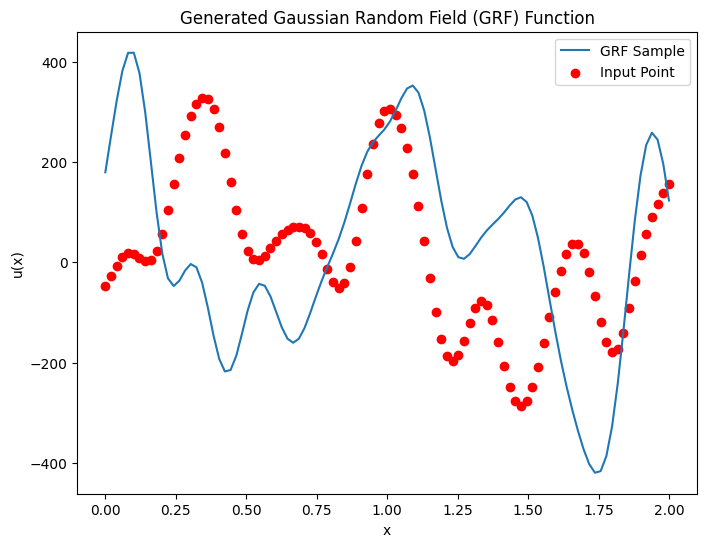

In [371]:
import numpy as np
import matplotlib.pyplot as plt

def exponential_quadratic_kernel(x1, x2, length_scale):
    distance_squared = np.sum((x1 - x2)**2)
    return np.exp(-distance_squared / (2 * length_scale**2))

def generate_grf(length_scale, amplitude):
    def grf_function(x):
        n = len(x)
        covariance_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                covariance_matrix[i, j] = exponential_quadratic_kernel(x[i], x[j], length_scale)

        # 生成均值为0的多维正态分布样本，然后乘以幅值因子
        mean = np.zeros(n)
        grf_sample = amplitude * np.random.multivariate_normal(mean, covariance_matrix)

        return grf_sample

    return grf_function
def finite_difference_solver(x_values, f_values, boundary_conditions,L=2.0,get_eigenvalue=False):
    # 参数设置
    N = len(x_values) # 格点数量
    h = L / (N-1)  # 网格步长
    print(f'h={h}')
    # 构建系数矩阵和右侧向量
    A = np.zeros((N, N))
    b = np.zeros(N)

    # 设置边界条件
    A[0, 0] = 1.0
    A[N-1, N-1] = 1.0
    b[0] = boundary_conditions[0]
    b[N-1] = boundary_conditions[1]

    # 构建系数矩阵和右侧向量
    for i in range(1, N-1):
        A[i, i-1] = -1 / h**2
        A[i, i] = +2 / h**2 + f_values[i]
        A[i, i+1] = -1 / h**2

    # 求解线性系统
    u = solve(A, b)
    if get_eigenvalue:
        N1 = int(1.0/h)
        eigenvalue = np.linalg.eigvals(A[1:N1,1:N1])
        return u,eigenvalue

    return u
# 示例：生成高斯随机场函数，并调整幅值
length_scale = 0.1
amplitude_factor = 200.0  # 调整的幅值因子

# 生成高斯随机场函数
grf_function = generate_grf(length_scale, amplitude_factor)

# 对任意输入进行函数调用
x_input = np.linspace(0, 2, 100)#np.array([0.2, 0.5, 0.8])
output_value = grf_function(x_input)

#print(f"Input: {x_input}, Output: {output_value}")

# 在一定范围内进行可视化
x_values = np.linspace(0, 2, 100)
grf_sample = grf_function(x_values)

# 可视化
plt.figure(figsize=(8, 6))
plt.plot(x_values, grf_sample, label='GRF Sample')
plt.scatter(x_input, output_value, color='red', label='Input Point')
plt.title('Generated Gaussian Random Field (GRF) Function')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()



In [321]:
len(x_values)

100

In [322]:
x_values[1]-x_values[0]

0.020202020202020204

h=0.01
u max=2.4040527022836597


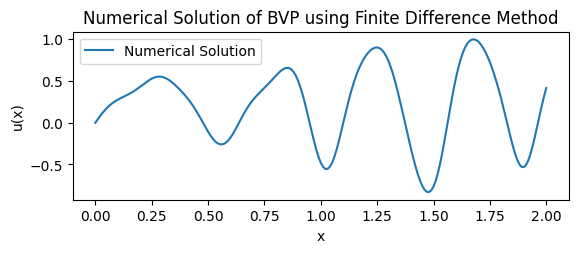

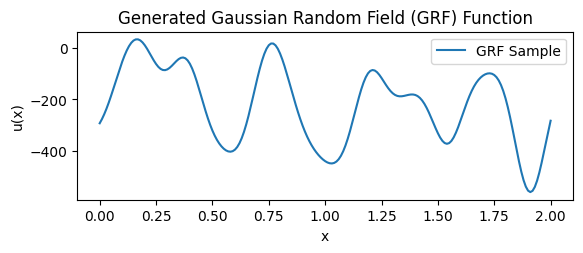

In [398]:
N = 201
L = 2.0
# 边界条件 u(0) = 0, u(2) = 1
boundary_conditions = (0, 1)
# 生成高斯随机场函数
x_values = np.linspace(0, L, N)
#grf_sample = -np.ones(N)*(np.pi**2+0.1)
grf_sample = grf_function(x_values)-200
#grf_sample = grf_sample*2
# 求解边值问题
u = finite_difference_solver(x_values=x_values, f_values=grf_sample, boundary_conditions=boundary_conditions)
u_max = np.max(np.abs(u))
u = u / u_max
# 可视化解
plt.subplot(211)
plt.plot(x_values, u, label='Numerical Solution')
print(f'u max={u_max}')
plt.title('Numerical Solution of BVP using Finite Difference Method')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()
plt.subplot(212)
# 可视化势函数
plt.plot(x_values, grf_sample, label='GRF Sample')
plt.title('Generated Gaussian Random Field (GRF) Function')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

In [389]:
u_max

3.471355224420826

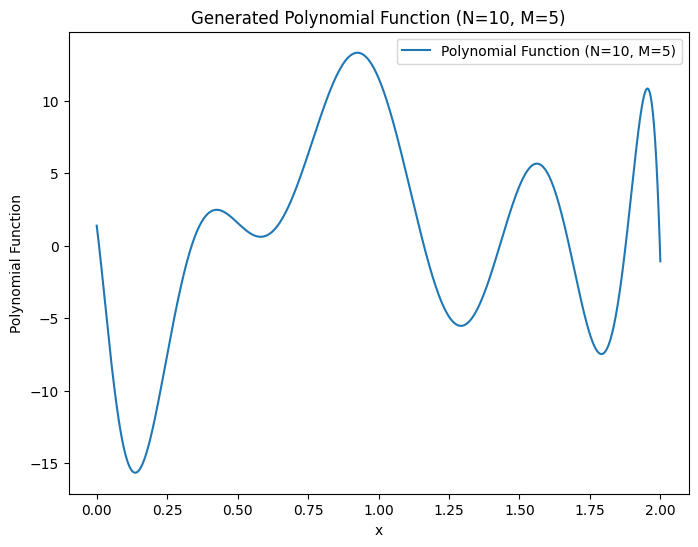

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def chebyshev_polynomial(x, n):
    return np.cos(n * np.arccos(x))

def generate_polynomial_function(N, M):
    coefficients = np.random.uniform(-M, M, N)

    def polynomial_function(x):
        result = 0
        for i in range(1, N+1):
            result += coefficients[i-1] * chebyshev_polynomial(x, i)
        return result

    return polynomial_function

# 示例：生成一个10阶多项式函数，系数绝对值不超过5
N = 10
M = 5

polynomial_function = generate_polynomial_function(N, M)

# 可视化多项式函数
x_values = np.linspace(-1, 1, 1000)
y_values = polynomial_function(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values+1, y_values, label=f'Polynomial Function (N={N}, M={M})')

plt.title(f'Generated Polynomial Function (N={N}, M={M})')
plt.xlabel('x')
plt.ylabel('Polynomial Function')
plt.legend()
plt.show()


In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

def finite_difference_solver(N, f, boundary_conditions):
    # 参数设置
    L = 2.0  # 区间长度
    x_values = np.linspace(0, L, N+1)  # 离散化空间
    h = L / N  # 网格步长

    # 构建系数矩阵和右侧向量
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # 设置边界条件
    A[0, 0] = 1.0
    A[N, N] = 1.0
    b[0] = boundary_conditions[0]
    b[N] = boundary_conditions[1]

    # 构建系数矩阵和右侧向量
    for i in range(1, N):
        A[i, i-1] = 1 / h**2
        A[i, i] = -2 / h**2 + f(x_values[i])
        A[i, i+1] = 1 / h**2

    # 求解线性系统
    u = solve(A, b)

    return x_values, u

# 示例势函数 f(x) = 1
def example_potential(x):
    return 1
def get_V_equiv(N,M):
    coefficients = np.random.uniform(-M, M, N)

    def V_equiv(x):
        result = 0
        for i in range(1, N+1):
            result += coefficients[i-1] * chebyshev_polynomial(x-1, i)
        return result

    return V_equiv#V_equiv(x)=V(x)-lam
V_equiv=get_V_equiv(10,50)   


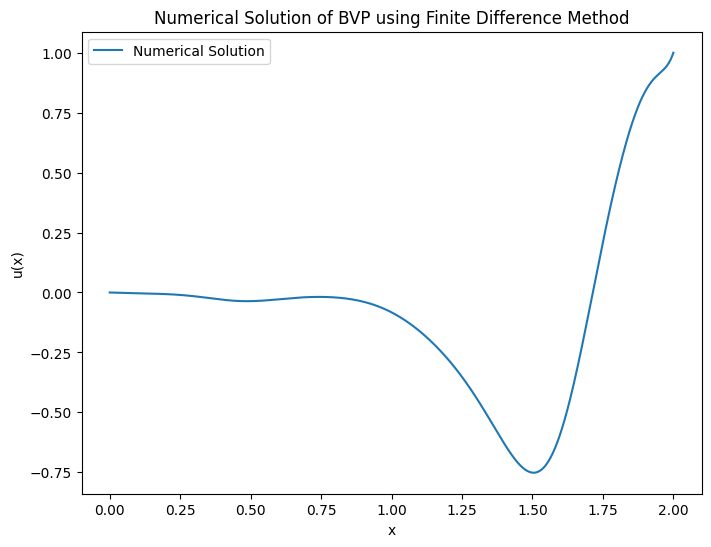

In [199]:
    
# 边界条件 u(0) = 0, u(2) = 1
boundary_conditions = (0, 1)

# 求解边值问题
N = 1000
x_values, u = finite_difference_solver(N, V_equiv, boundary_conditions)
u_max = np.max(np.abs(u))
u = u / u_max
# 可视化解
plt.figure(figsize=(8, 6))
plt.plot(x_values, u, label='Numerical Solution')

plt.title('Numerical Solution of BVP using Finite Difference Method')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()


In [200]:
u_max

1.0

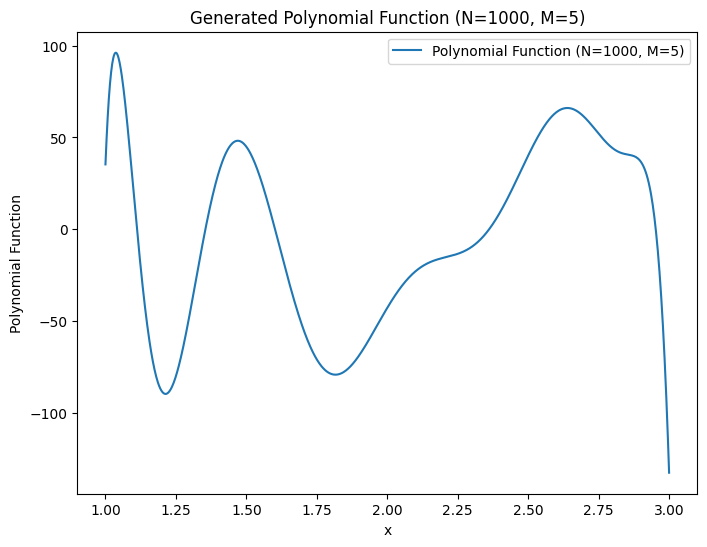

In [201]:
# 可视化多项式函数
x_values = np.linspace(0, 2, 1000)
y_values = V_equiv(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values+1, y_values, label=f'Polynomial Function (N={N}, M={M})')

plt.title(f'Generated Polynomial Function (N={N}, M={M})')
plt.xlabel('x')
plt.ylabel('Polynomial Function')
plt.legend()
plt.show()

In [186]:
lam

array([8.56186627])

In [98]:
L = 2
x_values = np.linspace(0, L, N+1)